In [1]:
from pathlib import Path
import pickle

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd()

# Setting up the system

In [4]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=2, F1=7 / 2, F=4
    )
]

polarizations = [[couplings.polarization_Z]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=2,
            F=3,
            F1=5 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=+1,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=3,
            F=4,
            F1=7 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        )
    ],
)

In [5]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    Ω0="phase_modulation(t, β, ωphase)*rabi_from_intensity(gaussian_2d_rotated(vz*t, y0+vy*t, peak_intensity, laser_center, 0.0, σz, σy, θ), main_coupling)",
    peak_intensity=1000.0,
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
    y0=0.0,
    vy=0.0,
    σz=4.53e-4,
    σy=1.04e-3,
    θ=-4.19,
    laser_center=5e-3,
    main_coupling=0.5,
)


In [6]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans, transition_selectors, verbose=True, qn_compact=True, decay_channels=None
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 1min 21s
Wall time: 2min


In [10]:
[QN.largest for QN in obe_system_original.QN]

[|X, J = 2, F₁ = 3/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 3, mF = -3, I₁ = 1/2, I₂ = 1/2, P

In [11]:
obe_system_original.H_symbolic

Matrix([
[-251619072761.694,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                          0,                         0,           0,                          0,                         0,                         0,                         0,               0,             0,                        0,                        0,          0,                        0,                       0,                        0,                        0,               0],
[                0, -251619072761.595,                 0,                 0,                 0,                 0,                 0,                 0,                0,                 0,                 0,                 0,                 0,                          0,                         0,           0,                          0,        

In [12]:
from copy import deepcopy

obe_system_python = deepcopy(obe_system_original)

In [15]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_python, transition_selectors, odepars
)

In [16]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 3, F₁ = 7/2, F = 4>"
states,
"|X, J = 2>",0.530151
"|X, J = 4>",0.469849


# Single trajectory run

In [17]:
ρ = utils.population.generate_uniform_population_states(
    states.QuantumSelector(J=2, F=3, electronic=states.ElectronicState.X), obe_system.QN
)

In [46]:
power = 25e-3

odepars.σz = 1.04e-3
odepars.σy = 4.53e-4

peak_intensity = power / (2 * np.pi * odepars.σz * odepars.σy)


In [112]:
odepars.peak_intensity = peak_intensity
odepars.main_coupling = obe_system.couplings[0].main_coupling.real
odepars.β = 0
odepars.σz = 1.04e-3
odepars.σy = 4.53e-4
odepars.laser_center = 10 * odepars.σz
odepars.θ = 4.19

problem = lindblad_julia.OBEProblem(
    odepars, ρ, tspan=(0, (odepars.laser_center * 2) / odepars.vz)
)
config = lindblad_julia.OBEProblemConfig(saveat=1e-6)


In [113]:
results = lindblad_julia.do_simulation_single(problem, config=config)

In [114]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

2.13 photons


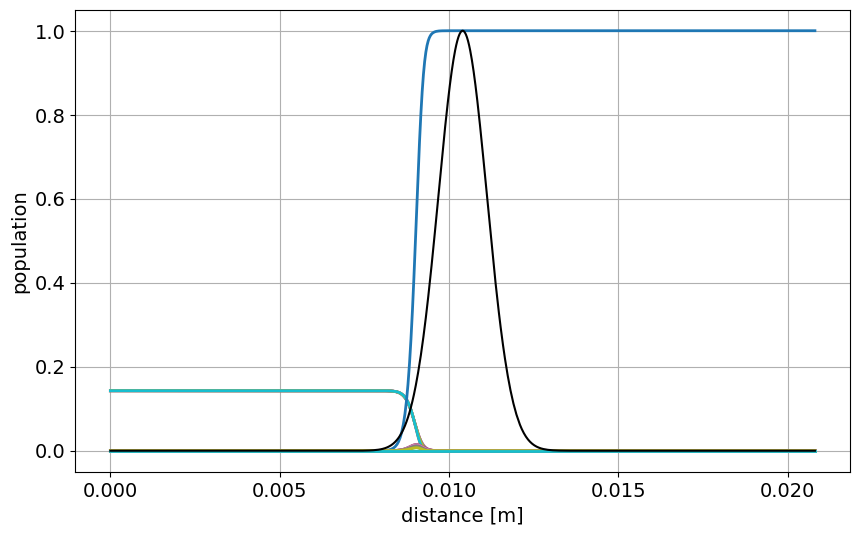

In [115]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results.t * odepars.vz, results.y.T, lw=2)
ax.set_xlabel("distance [m]")
ax.set_ylabel("population")

lc = odepars.get_parameter_evolution(results.t, "Ω0")
ax.plot(results.t * odepars.vz, lc / lc.max(), color="k")
ax.grid(True)

nphotons_prerc = np.trapz(results.y[indices_excited], x=results.t).sum() * hamiltonian.Γ
print(f"{nphotons_prerc:.2f} photons")

In [116]:
idx_max = np.argmax(lc)

idx_left = np.argmin((lc[:idx_max] - lc.max() / 2) ** 2)
idx_right = np.argmin((lc[idx_max:] - lc.max() / 2) ** 2) + idx_max

fwhm = (results.t * odepars.vz)[idx_right] - (results.t * odepars.vz)[idx_left]
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
sigma /= np.sqrt(2)  # rabi rate to intensity

print(f"sigma = {sigma:.2e}")


sigma = 5.12e-04


# Scan power for various trajectories

In [117]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [118]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

In [119]:
with open(cwd / "detection_1_nipple.pkl", "rb") as f:
    trajectories = pickle.load(f)

data = dict([(v, None) for v in list(trajectories.values())[0].keys()])

pop_mapping = {"mF=0": 3, "mF=2": 2, "mF=3": 2}


## Run simulation

In [122]:
results_scan = dict(
    [(v, dict([(mF, None) for mF in trajectories.keys()])) for v in data.keys()]
)

odepars.σz = 1.04e-3
odepars.σy = 4.53e-4
odepars.β = 0

power = 1e-3
peak_intensity = power / (2 * np.pi * odepars.σz * odepars.σy)

odepars.peak_intensity = peak_intensity

for voltage in list(data.keys())[::2]:
    ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
        method="Tsit5()",
        save_idxs=save_idxs,
        saveat=1e-6,
        abstol=1e-10,
        reltol=1e-7,
    )

    problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 100e-6))

    for mF in trajectories:
        ts = trajectories[mF][voltage][0]
        xs = trajectories[mF][voltage][1]
        vs = trajectories[mF][voltage][2]

        dt = odepars.laser_center / vs[:, 2]

        scan_values = [vs[:, 0], vs[:, 1], vs[:, 2], xs[:, 1] - vs[:, 1] * dt]
        parameters = ["vx", "vy", "vz", "y0"]

        output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(
            nphotons=True
        )

        ensemble_problem = lindblad_julia.OBEEnsembleProblem(
            problem=problem,
            parameters=parameters,
            scan_values=scan_values,
            output_func=output_func,
            zipped=True,
        )

        lindblad_julia.setup_problem_parameter_scan(ensemble_problem)

        lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

        results = lindblad_julia.get_results_parameter_scan(ensemble_problem)
        results_scan[voltage][mF] = results


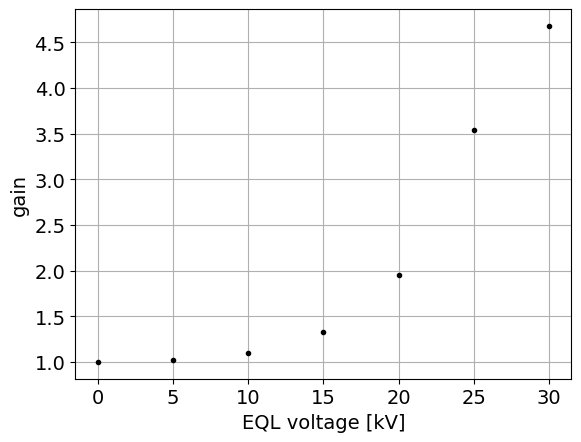

In [123]:
signal = []
voltages = []

for v, res in results_scan.items():
    for mF in res.keys():
        if res[mF] is None:
            break

        if len(voltages) == 0:
            voltages.append(v)
        if voltages[-1] != v:
            voltages.append(v)

        signal.append(res[mF].results.sum() * pop_mapping[mF])

voltages = np.array(voltages)
signal = np.array(signal).reshape(-1, 3).sum(axis=1)

fig, ax = plt.subplots()

ax.plot(voltages / 1e3, signal / signal[0], ".", color="k")

ax.set_xlabel("EQL voltage [kV]")
ax.set_ylabel("gain")

ax.grid()


In [ ]:
results_scan = dict(
    [(v, dict([(mF, None) for mF in trajectories.keys()])) for v in data.keys()]
)

power = 30e-3
peak_intensity = power / (2 * np.pi * odepars.σz * odepars.σy)

odepars.peak_intensity = peak_intensity
odepars.β = 4

for voltage in list(data.keys())[::2]:
    ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
        method="Tsit5()",
        save_idxs=save_idxs,
        saveat=1e-6,
        abstol=1e-10,
        reltol=1e-7,
    )

    problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 50e-6))

    for mF in trajectories:
        ts = trajectories[mF][voltage][0]
        xs = trajectories[mF][voltage][1]
        vs = trajectories[mF][voltage][2]

        dt = odepars.laser_center / vs[:, 2]

        scan_values = [vs[:, 0], vs[:, 1], vs[:, 2], xs[:, 1] - vs[:, 1] * dt]
        parameters = ["vx", "vy", "vz", "y0"]

        output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(
            nphotons=True
        )

        ensemble_problem = lindblad_julia.OBEEnsembleProblem(
            problem=problem,
            parameters=parameters,
            scan_values=scan_values,
            output_func=output_func,
            zipped=True,
        )

        lindblad_julia.setup_problem_parameter_scan(ensemble_problem)

        lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

        results = lindblad_julia.get_results_parameter_scan(ensemble_problem)
        results_scan[voltage][mF] = results


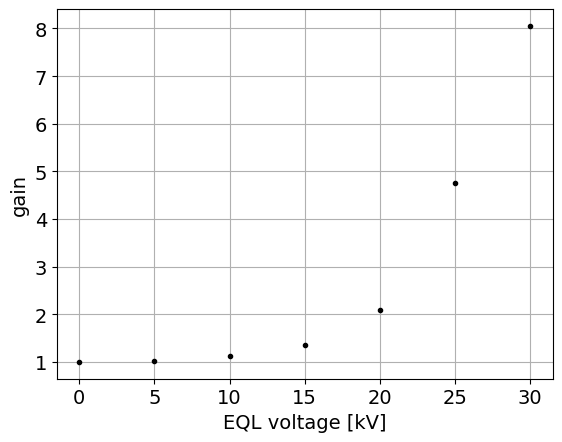

In [ ]:
signal = []
voltages = []

for v, res in results_scan.items():
    for mF in res.keys():
        if res[mF] is None:
            break

        if len(voltages) == 0:
            voltages.append(v)
        if voltages[-1] != v:
            voltages.append(v)

        signal.append(res[mF].results.sum() * pop_mapping[mF])

voltages = np.array(voltages)
signal = np.array(signal).reshape(-1, 3).sum(axis=1)

fig, ax = plt.subplots()

ax.plot(voltages / 1e3, signal / signal[0], ".", color="k")

ax.set_xlabel("EQL voltage [kV]")
ax.set_ylabel("gain")

ax.grid()


In [ ]:
fwhm = 2 * np.sqrt(2 * np.log(2)) * odepars.σz
waist = np.sqrt(2) * fwhm / (2 * np.sqrt(np.log(2)))

peak_intensity = 2 * power / (np.pi * waist**2)

peak_intensity


1193.6620731892147